#### FA23 DAAN570 - Deep Learning
#### Project: UAV Control using CNN and ViT Gesture Recognition
#### Model: CNN Model 11b (selected model for our application)
##### Students: Aureo Zanon and Johnny Zielinski (Team 15)
##### Date: December 6th, 2023.

In [51]:
# Loading the required libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [52]:
# Setting the base_path to the images 
base_path = '//Users//aureozanon//Documents//DAAN570//Project//HG_Data//'  # Feel free to use your actual path to the 'images' directory (we also changed it to connect to the AWS S3 bucket after some IAM config)

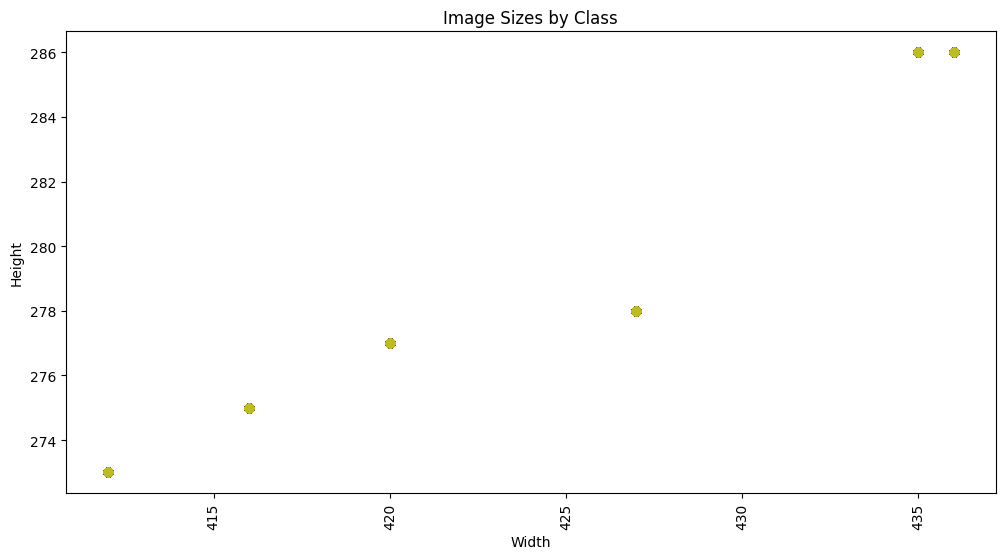

In [68]:
# Visualizing the different images sizes and formats

# Initialize dictionaries to store image sizes and formats
image_sizes = {}
image_formats = {}

# Iterate over each class directory
for class_dir in os.listdir(base_path):
    class_dir_path = os.path.join(base_path, class_dir)
    if os.path.isdir(class_dir_path):
        image_sizes[class_dir] = []
        image_formats[class_dir] = []

        # Iterate over each image in the class directory
        for img_file in os.listdir(class_dir_path):
            img_path = os.path.join(class_dir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    # Store image sizes and formats
                    image_sizes[class_dir].append(img.size)
                    image_formats[class_dir].append(img.format)
            except IOError:
                pass  # Ignore files that are not images

# Plotting image sizes
plt.figure(figsize=(12, 6))
for class_dir, sizes in image_sizes.items():
    widths, heights = zip(*sizes)
    plt.scatter(widths, heights, label=class_dir)
plt.xlabel('Width')
plt.ylabel('Height')
plt.xticks(rotation=90) 
plt.title('Image Sizes by Class')
plt.show()


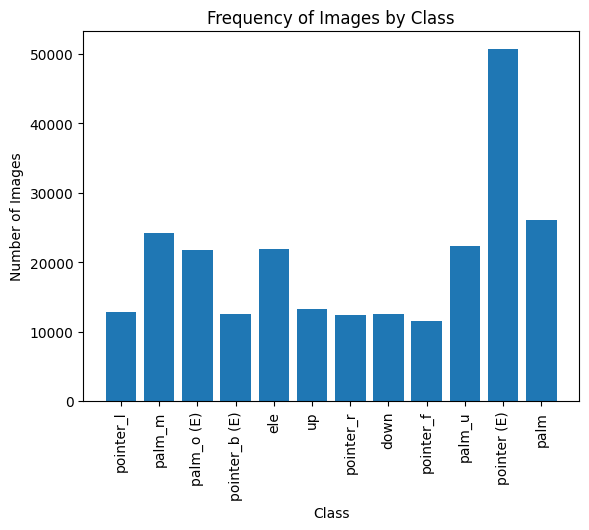

In [7]:
# Checking for imbalanced data

class_counts = {}

for class_folder in os.listdir(base_path):
    class_path = os.path.join(base_path, class_folder)
    if os.path.isdir(class_path):
        class_counts[class_folder] = len(os.listdir(class_path))

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.xticks(rotation=90) 
plt.ylabel('Number of Images')
plt.title('Frequency of Images by Class')
plt.show()


In [8]:
# Resizing all images to a common size of 224x224 pixels.
target_size = (224, 224)

In [81]:
# Cutmix Augmentation Exploration

def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w



def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [33]:
# Creating an instance of the ImageDataGenerator class with specified augmentation parameters:
datagen = ImageDataGenerator(
    rescale=1./255,           # Rescales the pixel values in images to the range [0, 1].
    rotation_range=40,        # Randomly rotates images within this degree range.
    width_shift_range=0.2,    # Randomly shifts images horizontally by a fraction of the total width.
    height_shift_range=0.2,   # Randomly shifts images vertically by a fraction of the total height.
    shear_range=0.2,          # Randomly applies shearing transformations.
    zoom_range=0.2,           # Randomly zooms inside the images.
    horizontal_flip=True,     # Randomly flips half of the images horizontally.
    validation_split=0.1      # Decided to use 10% of the data as validation (test) set due to the large size of our dataset
)

# Using a subset of the original dataset with 9 classes that were previously selected. Excluded classes: palm_o, pointer, and pointer_b

In [36]:
# Creating the training and validation generators
train_generator = datagen.flow_from_directory(
    base_path,                      # Specify the path to the directory with training images
    target_size=target_size,        # Define the target size of the images (e.g., (224, 224))
    batch_size=32,                  # Set the size of the batches of data (number of images per batch)
    class_mode='categorical',       # Set the class mode to 'categorical' for multi-class classification
    subset='training',               # Specify that this is for the training subset
)

validation_generator = datagen.flow_from_directory(
    base_path,                      # Specify the path to the directory with validation images
    target_size=target_size,        # Define the target size of the images (e.g., (224, 224))
    batch_size=32,                  # Set the size of the batches of data (number of images per batch)
    class_mode='categorical',       # Set the class mode to 'categorical' for multi-class classification
    subset='validation',             # Specify that this is for the validation subset
)


Found 141305 images belonging to 9 classes.
Found 15697 images belonging to 9 classes.


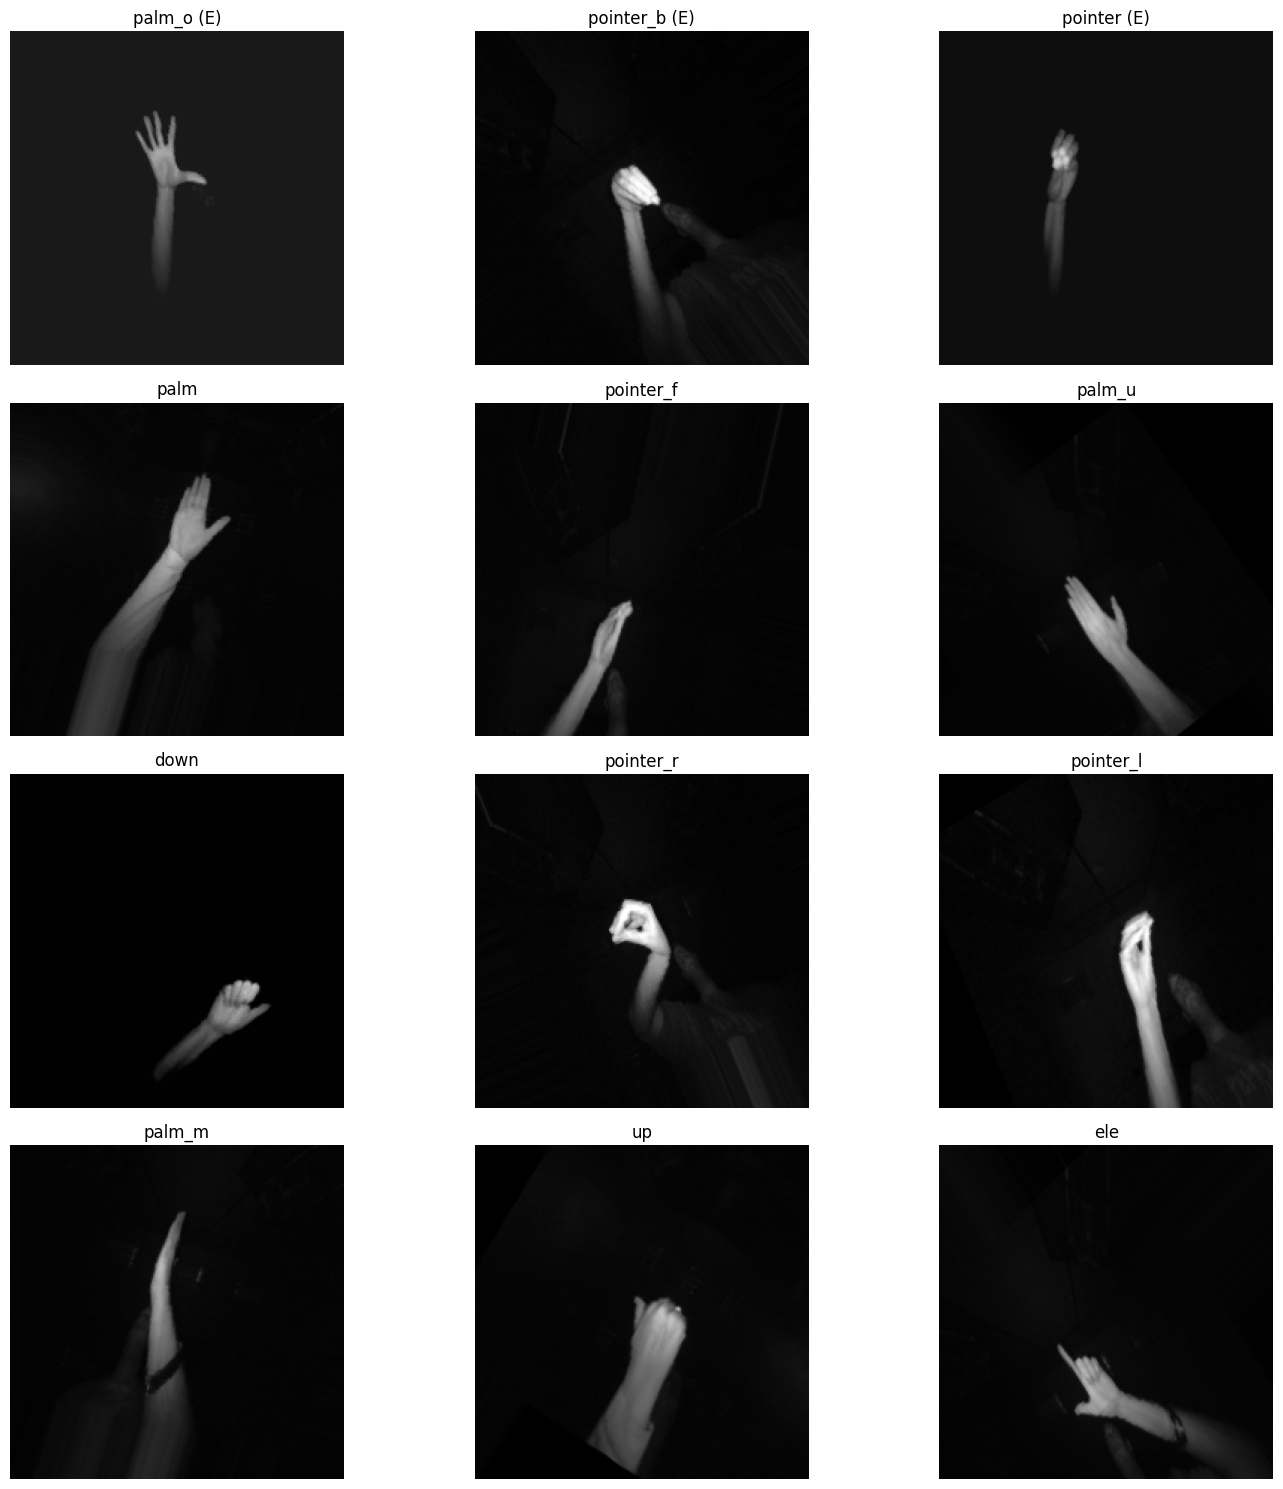

In [19]:
# Initialize a dictionary to store one sample per class
samples_per_class = {}
class_labels = dict((v,k) for k,v in validation_generator.class_indices.items())
seed = 74

# Iterate over the generator and collect one sample per class
for _ in range(len(validation_generator)):
    X_batch, y_batch = next(validation_generator)
    class_index = np.argmax(y_batch[0])
    if class_index not in samples_per_class:
        samples_per_class[class_index] = X_batch[0]
    if len(samples_per_class) == len(validation_generator.class_indices):
        break

# Display the collected samples with class names as captions
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
for i, (class_index, image) in enumerate(samples_per_class.items()):
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(class_labels[class_index])  # Set the title to the class name
plt.tight_layout()
plt.show()


In [24]:
# Defining the CNN architecture
model = Sequential([
    Input(shape=(224, 224, 3)),           # Define the input layer with the shape 224x224 and 3 color channels
    Conv2D(32, (3, 3)),                   # First convolutional layer with 32 filters of size 3x3
    LeakyReLU(alpha=0.1),                 # Leaky ReLU activation function with alpha set to 0.1
    MaxPooling2D(pool_size=(2, 2)),       # First max pooling layer with pool size 2x2
    Conv2D(32, (3, 3)),                   # Second convolutional layer with 32 filters of size 3x3
    LeakyReLU(alpha=0.1),                 # Leaky ReLU activation function with alpha set to 0.1
    Conv2D(64, (3, 3)),                   # Third convolutional layer with 64 filters of size 3x3
    LeakyReLU(alpha=0.1),                 # Leaky ReLU activation function with alpha set to 0.1
    MaxPooling2D(pool_size=(2, 2)),       # Second max pooling layer with pool size 2x2
    Conv2D(64, (3, 3)),                   # Fourth convolutional layer with 64 filters of size 3x3
    LeakyReLU(alpha=0.1),                 # Leaky ReLU activation function with alpha set to 0.1
    MaxPooling2D(pool_size=(2, 2)),       # Third max pooling layer with pool size 2x2
    Flatten(),                            # Flatten the output to feed it into the dense layers
    Dense(128, kernel_regularizer=l2(0.001)),  # Dense layer with 128 units and L2 regularization at 0.001
    LeakyReLU(alpha=0.1),                 # Leaky ReLU activation function with alpha set to 0.1
    Dropout(0.5),                         # Dropout layer with 50% dropout rate to reduce overfitting
    Dense(len(train_generator.class_indices), activation='sigmoid', kernel_regularizer=l2(0.001))  # Output layer with units equal to the number of classes, using sigmoid activation and L2 regularization
])


In [25]:
# Compiling the CNN model
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# model compiled using the SGD optimizer, with learning rate of 0.001 and momentum of 0.9 (tried other combinations in previous models)
# used the categorical_crossentropy loss and set accuracy as the metrics.

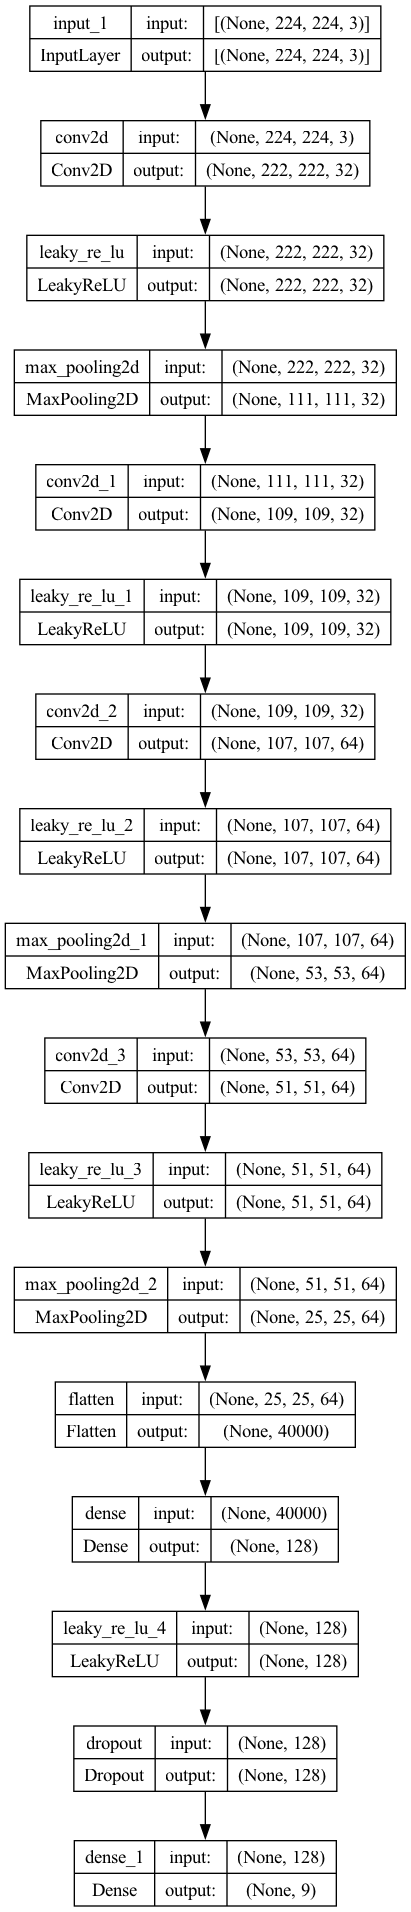

In [82]:
plot_model(model, to_file='CNN_Model11_AZ.png', show_shapes=True, show_layer_names=True)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 109, 109, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 64)      18496     
                                                        

In [9]:
# Training the CNN model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=(train_generator.samples // train_generator.batch_size) + (train_generator.samples % train_generator.batch_size > 0),
    validation_data=validation_generator,
    validation_steps=(validation_generator.samples // validation_generator.batch_size) + (validation_generator.samples % validation_generator.batch_size > 0),
    epochs=15
)

Epoch 1/15
4416/4416 [==============================] - 3505s 794ms/step - loss: 1.7753 - accuracy: 0.4270 - val_loss: 1.1735 - val_accuracy: 0.6437
Epoch 2/15
4416/4416 [==============================] - 3220s 729ms/step - loss: 0.9326 - accuracy: 0.7321 - val_loss: 0.9427 - val_accuracy: 0.7158
Epoch 3/15
4416/4416 [==============================] - 3238s 733ms/step - loss: 0.7175 - accuracy: 0.8191 - val_loss: 0.8219 - val_accuracy: 0.7579
Epoch 4/15
4416/4416 [==============================] - 3219s 729ms/step - loss: 0.5956 - accuracy: 0.8611 - val_loss: 0.5512 - val_accuracy: 0.8806
Epoch 5/15
4416/4416 [==============================] - 3204s 726ms/step - loss: 0.5183 - accuracy: 0.8872 - val_loss: 0.5192 - val_accuracy: 0.8889
Epoch 6/15
4416/4416 [==============================] - 3199s 724ms/step - loss: 0.4590 - accuracy: 0.9041 - val_loss: 0.5463 - val_accuracy: 0.8660
Epoch 7/15
4416/4416 [==============================] - 3094s 701ms/step - loss: 0.4090 - accuracy: 0.9180

In [10]:
# Saving the model
model.save('//Users//aureozanon//Documents//DAAN570//Project//Models//hg_cnn_az_11b.h5')
model.save('//Users//aureozanon//Documents//DAAN570//Project//Models//hg_cnn_az_11b.keras')
model.save_weights('//Users//aureozanon//Documents//DAAN570//Project//Models//hg_cnn_weights_az_11b.h5')

/Users/aureozanon/anaconda3/envs/DAAN570/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# Evaluating the model on the validation (tes) dataset
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

491/491 [==============================] - 132s 269ms/step - loss: 0.2919 - accuracy: 0.9365
Test accuracy: 93.65%


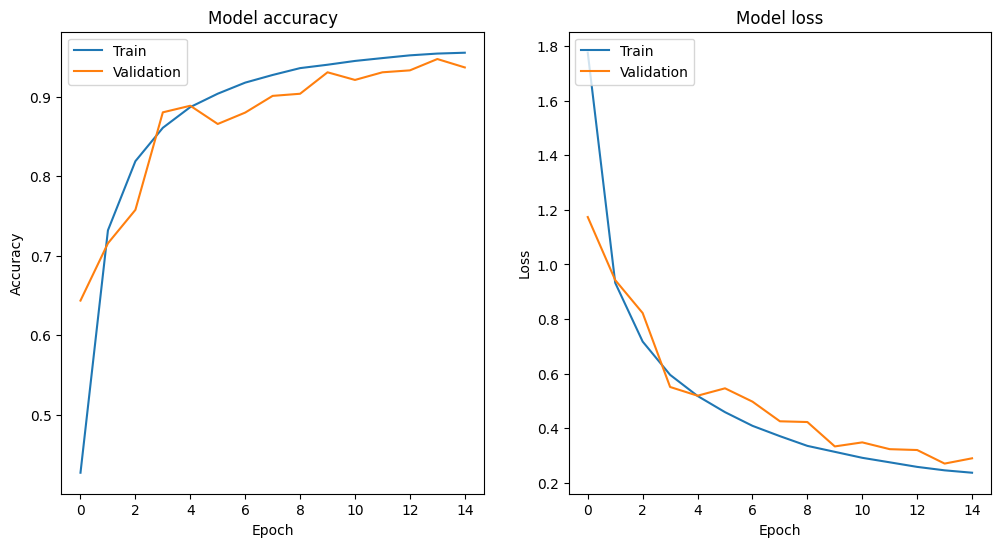

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [77]:
# Loading the model (in case it is not in the memory) 
model = load_model('//Users//aureozanon//Documents//DAAN570//Project//Models//hg_cnn_az_11b.h5')

#model.save('//Users//aureozanon//Documents//DAAN570//Project//Models//hg_cnn_az_Model02.keras')

In [79]:
# Retrieve class labels from the validation_generator
class_labels = list(validation_generator.class_indices.keys())
print(class_labels)

['down', 'ele', 'palm', 'palm_m', 'palm_u', 'pointer_f', 'pointer_l', 'pointer_r', 'up']


313/313 [==============================] - 50s 154ms/step


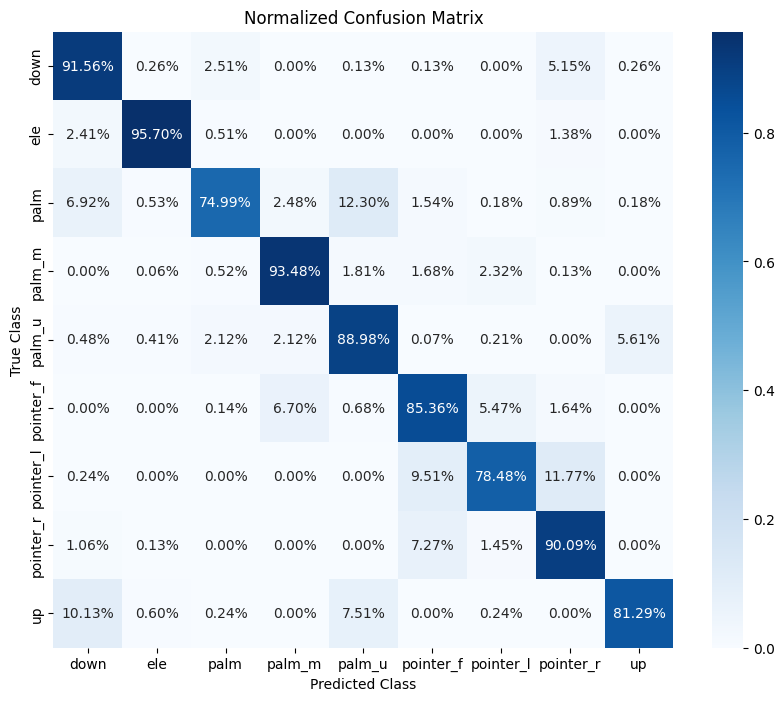

In [80]:
# Setting a seed value for reproducibility of the sample
seed = 74

# Sampling a batch of data from the validation_generator
# Generating the Precision, Recall, and F1-score metrics
x_val_samples = []
y_val_samples = []
sample_count = 0

# Loop until you have accumulated 10000 samples
while sample_count < 10000:
    x_batch, y_batch = validation_generator.next()
    x_val_samples.append(x_batch)
    y_val_samples.append(y_batch)
    sample_count += x_batch.shape[0]

    # Check if we have gathered enough samples
    if sample_count >= 10000:
        break

# Concatenate all batches
x_val_sample = np.concatenate(x_val_samples, axis=0)[:10000]
y_val_sample = np.concatenate(y_val_samples, axis=0)[:10000]


# Generating predictions for this batch using the trained model
# predictions will be in the format of probabilities for each class
predictions = model.predict(x_val_sample)

# Converting the prediction probabilities to class indices (highest probability)
# np.argmax is used to find the index of the maximum value across the prediction axis
predicted_classes = np.argmax(predictions, axis=1)

# Convert the true labels from one-hot encoded format to class indices
# This is required to compare with the predicted classes
true_classes = np.argmax(y_val_sample, axis=1)

# Generating the confusion matrix from true and predicted classes
# The confusion matrix gives a summary of how well the model is classifying each class
# Note: It has been used in previous versions of the model to select the subset of 9 out of 12 classes
cm = confusion_matrix(true_classes, predicted_classes)

# Normalizing the confusion matrix so that each row sums to 1
# This helps in comparing classes of different sizes by showing the proportion of correct/incorrect predictions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Retrieving class labels from the validation_generator
# This will be used to label the axes of the confusion matrix
class_labels = list(validation_generator.class_indices.keys())

# Plotting the normalized confusion matrix using Seaborn
# sns.heatmap creates a heatmap, and 'annot=True' adds annotations to each cell in the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [49]:
# Generating the Precision, Recall, and F1-score metrics
seed = 74
x_val_samples = []
y_val_samples = []
sample_count = 0

# Loop until you have accumulated 10000 samples
while sample_count < 10000:
    x_batch, y_batch = validation_generator.next()
    x_val_samples.append(x_batch)
    y_val_samples.append(y_batch)
    sample_count += x_batch.shape[0]

    # Check if we have gathered enough samples
    if sample_count >= 10000:
        break

# Concatenate all batches
x_val_sample = np.concatenate(x_val_samples, axis=0)[:10000]
y_val_sample = np.concatenate(y_val_samples, axis=0)[:10000]

# Generate predictions for the sample batch
predictions = model.predict(x_val_sample)

# Convert predictions and true labels from one-hot encoded to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val_sample, axis=1)

# Retrieve class labels from the validation_generator
class_labels = list(validation_generator.class_indices.keys())

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)



313/313 [==============================] - 46s 146ms/step
              precision    recall  f1-score   support

        down       0.74      0.91      0.82       755
         ele       0.97      0.94      0.96      1454
        palm       0.94      0.76      0.84      1614
      palm_m       0.93      0.93      0.93      1552
      palm_u       0.82      0.90      0.86      1451
   pointer_f       0.77      0.86      0.81       727
   pointer_l       0.88      0.75      0.81       821
   pointer_r       0.78      0.92      0.84       801
          up       0.89      0.83      0.86       825

    accuracy                           0.87     10000
   macro avg       0.86      0.87      0.86     10000
weighted avg       0.88      0.87      0.87     10000



#### Observation: Testing a sample of 10,000 images from the validation_generator. The Pointer-l (pointing to the left) and pointer_r (pointing to the right), and the up (go up) and down (go down) hand gestures present a challenge and should be further refined to avoid miscommand of the drone.